**Автор: Анна Смелова**

## Решение домашнего задания к уроку 7 "Классификация с помощью KNN. Кластеризация K-means"

### Задание 1
Используя файл Lesson_7_extended.ipynb (он в web7.zip в материалах)::
#### К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

import warnings
warnings.filterwarnings('ignore')

Будем определять вес **от расстояния $d$:**

### - $w(d) = q^{d}$,   $q \in (0,1)$;

### Реализация алгоритма kNN<a class='anchor' id='implement_knn'>

Загрузим один из "игрушечных" датасетов из sklearn.

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

Разделим выборку на обучающую и тестовую

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

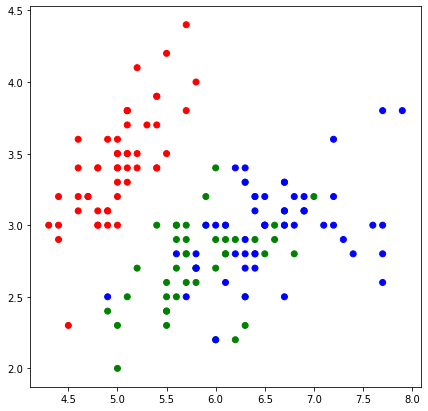

In [4]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [5]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
        
    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

Реализуем алгоритм поиска k ближайших соседей.

In [6]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

Реализуем "взвешенный" алгоритм поиска k ближайших соседей.

In [7]:
# ИЗМЕНЕНИЯ добавила параметр q для вычисления веса
def knn_weighted(x_train, y_train, x_test, k, q=1):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            # ИЗМЕНЕНИЯ расчет веса
            w = q**d[0]
            classes[d[1]] += w #1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

Напишем функцию для вычисления точности

In [8]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Проверим работу алгоритмов при различных k

Построим график распределения классов.

In [9]:
def get_graph(X_train, y_train, k, q):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    print(np.c_[xx.ravel(), yy.ravel()].shape)

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)
    Zw = knn_weighted(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k, q)
    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    Zw = np.array(Z).reshape(xx.shape)
    
    plt.figure(figsize=(16,7))
    
    plt.subplot(1,2,1)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, Zw, cmap=cmap_light)
    
    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая 'взвешенная' kNN классификация при k = {k} и q = {q}")
    
    plt.show()

Точность алгоритма при k = 2: 0.733
Точность "взвешенного" алгоритма при k = 2 и q = 0.5: 0.700
(58800, 2)


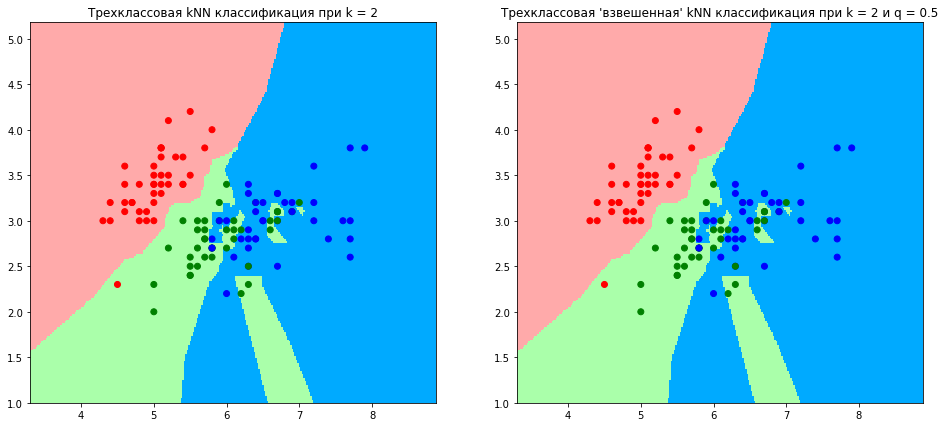

CPU times: user 3min 52s, sys: 687 ms, total: 3min 52s
Wall time: 3min 58s


In [10]:
%%time
k = 2
q = 0.5

y_pred = knn(X_train, y_train, X_test, k)
y_pred_weighted = knn_weighted(X_train, y_train, X_test, k, q)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')
print(f'Точность "взвешенного" алгоритма при k = {k} и q = {q}: {accuracy(y_pred_weighted, y_test):.3f}')
get_graph(X_train, y_train, k, q)

Точность алгоритма при k = 5: 0.733
Точность "взвешенного" алгоритма при k = 5 и q = 0.5: 0.733
(58800, 2)


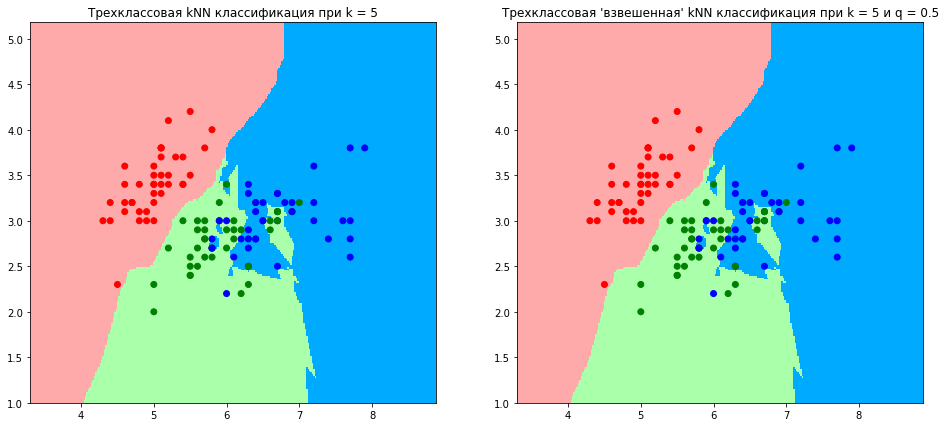

CPU times: user 3min 39s, sys: 159 ms, total: 3min 39s
Wall time: 3min 39s


In [11]:
%%time
k = 5
q = 0.5

y_pred = knn(X_train, y_train, X_test, k)
y_pred_weighted = knn_weighted(X_train, y_train, X_test, k, q)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')
print(f'Точность "взвешенного" алгоритма при k = {k} и q = {q}: {accuracy(y_pred_weighted, y_test):.3f}')
get_graph(X_train, y_train, k, q)

Точность алгоритма при k = 10: 0.767
Точность "взвешенного" алгоритма при k = 10 и q = 0.5: 0.767
(58800, 2)


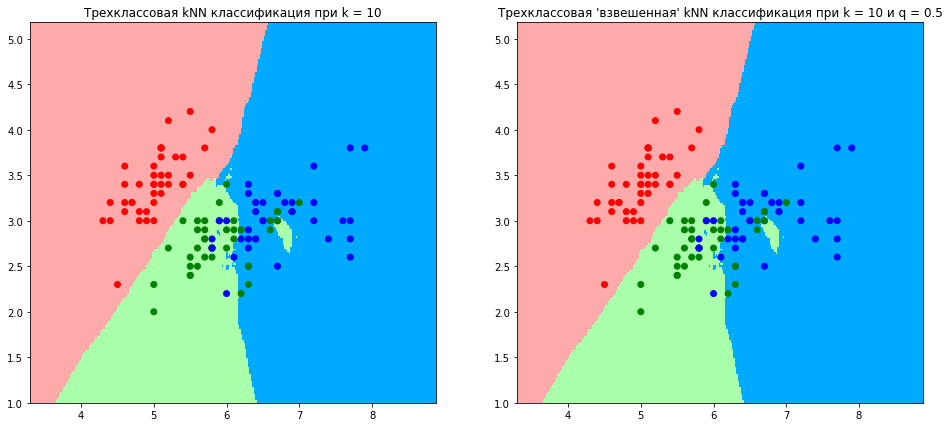

CPU times: user 3min 42s, sys: 444 ms, total: 3min 42s
Wall time: 3min 45s


In [12]:
%%time
k = 10
q = 0.5

y_pred = knn(X_train, y_train, X_test, k)
y_pred_weighted = knn_weighted(X_train, y_train, X_test, k, q)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')
print(f'Точность "взвешенного" алгоритма при k = {k} и q = {q}: {accuracy(y_pred_weighted, y_test):.3f}')
get_graph(X_train, y_train, k, q)

Точность алгоритма при k = 10: 0.767
Точность "взвешенного" алгоритма при k = 10 и q = 0.1: 0.733
(58800, 2)


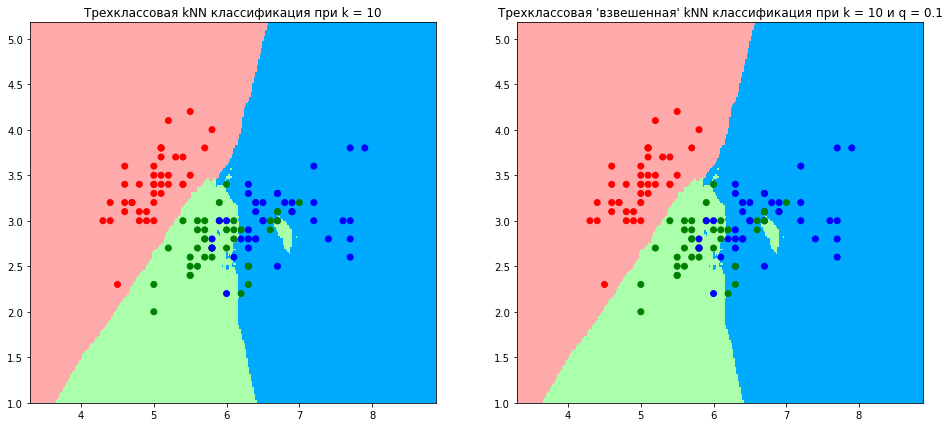

CPU times: user 3min 42s, sys: 408 ms, total: 3min 42s
Wall time: 3min 44s


In [13]:
%%time
k = 10
q = 0.1

y_pred = knn(X_train, y_train, X_test, k)
y_pred_weighted = knn_weighted(X_train, y_train, X_test, k, q)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')
print(f'Точность "взвешенного" алгоритма при k = {k} и q = {q}: {accuracy(y_pred_weighted, y_test):.3f}')
get_graph(X_train, y_train, k, q)

Точность алгоритма при k = 10: 0.767
Точность "взвешенного" алгоритма при k = 10 и q = 0.9: 0.767
(58800, 2)


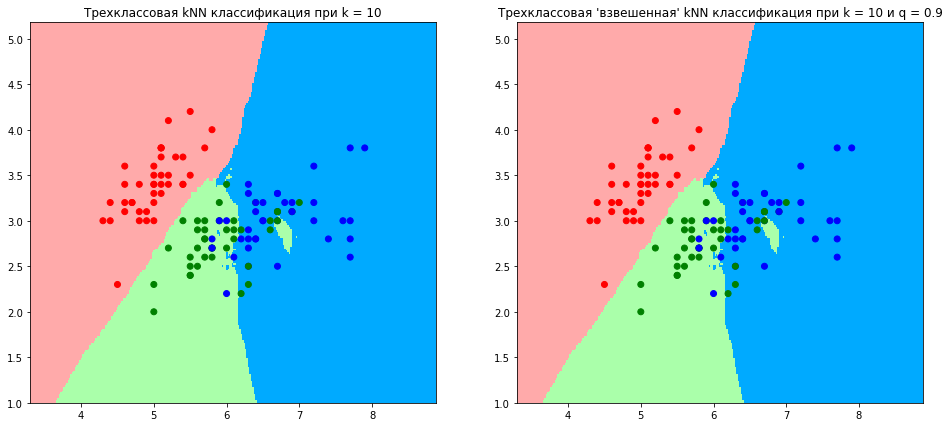

CPU times: user 3min 35s, sys: 161 ms, total: 3min 35s
Wall time: 3min 36s


In [14]:
%%time
k = 10
q = 0.9

y_pred = knn(X_train, y_train, X_test, k)
y_pred_weighted = knn_weighted(X_train, y_train, X_test, k, q)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')
print(f'Точность "взвешенного" алгоритма при k = {k} и q = {q}: {accuracy(y_pred_weighted, y_test):.3f}')
get_graph(X_train, y_train, k, q)

С увеличением q и k точность немного растет. У "взвешенного" алгоритма точность получилась либо хуже, либо такая же по сравнению с обычным. Визуально разделяющие плоскости вроде вообще не отличаются. Может, чтобы увидеть различия, нужно больше данных.

### Задание 2*
Используя файл Lesson_7_extended.ipynb (он в web7.zip в материалах)::
#### Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

Среднее квадратичное внутрикластерное расстояние:
$$\sum_{k=1}^{K}\frac{1}{|k|}\sum_{i=1}^{l}[a(x_{i})=k]\rho^{2}(x_{i}, c_{k}),$$

Сначала сгенерируем три облака точек с помощью инструментов `sklearn`.

In [15]:
from sklearn.datasets import make_blobs, make_moons

X, y = make_blobs(n_samples=100, random_state=1)

Изобразим точки на графике.

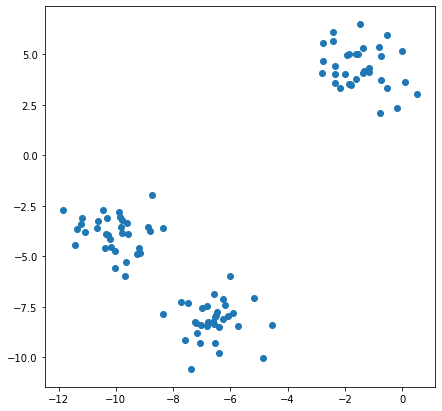

In [16]:
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1]);

В качестве метрики расстояния будем использовать евклидово расстояние, функция для которого была написана ранее. В качестве центроидов выберем первые k элементов датасета. Реализуем основной цикл алгоритма.

In [17]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для кластеризации
    clusters = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # кластеризуем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            cluster = distances.index(min(distances))
            clusters[cluster].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for cluster in clusters:
            centroids[cluster] = np.mean(clusters[cluster], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.linalg.norm(centroids[centroid] - old_centroids[centroid], ord=2) > min_distance:
                optimal = False
                break
        
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, clusters

In [18]:
# Среднее квадратичное внутрикластерное расстояние
def msd(centroids, clusters):
    result = 0
    for i, centroid in enumerate(centroids):
        result += np.mean([e_metrics(cluster, centroid)**2 for cluster in clusters[i]])
    return result

In [19]:
# определим максимальное количество итераций
max_iterations = 1
# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4
# сразу определим массив количества кластеров
a_k = list(np.arange(1,11))

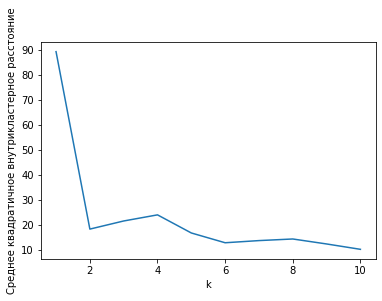

In [20]:
# Построим график зависимости среднего квадратичного внутрикластерного расстояния от количества кластеров
values = []

for k in a_k:
    centroids, clusters = kmeans(X, k, max_iterations, min_distance)
    values.append(msd(centroids, clusters))
    
plt.plot(a_k, values)
plt.xlabel('k')
plt.ylabel('Среднее квадратичное внутрикластерное расстояние')
plt.show()

С увеличением количества кластеров среднее квадратичное внутрикластерное расстояние убывает. Есть точка перегиба (в нашем случае 2 кластера), после которой скорость убывания снижается. Хотя в нашем случае визуально прослеживается 3 класса, судя по метрике 2 кластера было бы оптимальней. 

### Задание 3*
Используя файл Lesson_7_extended.ipynb (он в web7.zip в материалах)::
#### Оптимизировать код для KNN (оставить один цикл, либо обойтись без циклов вообще).

In [21]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

In [22]:
# Убрала один цикл по x_train
def knn_opt_1(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
        
        distance = list(map(lambda el: e_metrics(x, el), X_train))
        test_distances = list(zip(distance,y_train))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

In [23]:
# Убрала еще один цикл по x_test
def incr_dict(classes, test_distances, k):
    # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
    for d in sorted(test_distances)[0:k]:
        classes[d[1]] += 1
    
    return classes
    
def knn_opt_2(x_train, y_train, x_test, k):
    answers = []
    
    classes = list(map(lambda x: incr_dict({class_item: 0 for class_item in set(y_train)}, 
                            list(zip(list(map(lambda el: e_metrics(x, el), X_train)),y_train)), k), x_test))
    
    answers = list(map(lambda cl: sorted(cl, key=cl.get)[-1], classes))
        
    return answers

In [24]:
%%time
y_pred = knn(X_train, y_train, X_test, 2)

CPU times: user 64.2 ms, sys: 1.9 ms, total: 66.1 ms
Wall time: 65.3 ms


In [25]:
%%time
y_pred_opt_1 = knn_opt_1(X_train, y_train, X_test, 2)

CPU times: user 67.1 ms, sys: 2.28 ms, total: 69.4 ms
Wall time: 68.5 ms


In [26]:
%%time
y_pred_opt_2 = knn_opt_2(X_train, y_train, X_test, 2)

CPU times: user 73.8 ms, sys: 2.73 ms, total: 76.6 ms
Wall time: 77 ms


In [27]:
y_pred_opt_1 == y_pred and y_pred_opt_2 == y_pred

True

Не придумала, как избавиться от цикла со словарем, поэтому просто вынесла его в функцию. Работает примерно так же по времени, но код стал вообще не читаемым. Из-за этого не люблю функциональный подход к программированию. 